# ЛР1: Анализ аномалий в вакансиях разработчиков

## Обзор задания
Данный notebook реализует комплексный анализ вакансий разработчиков с API HH.ru, фокусируясь на обнаружении аномалий в данных о зарплатах с использованием методов машинного обучения без учителя.

## Цели
1. Собрать 2000 вакансий разработчиков с информацией о зарплате
2. Создать структурированный DataFrame с релевантными полями
3. Обработать данные о зарплатах и обнаружить аномалии
4. Применить несколько методов обнаружения аномалий без учителя
5. Проанализировать и категоризировать обнаруженные аномалии
6. Экспортировать результаты для дальнейшего анализа

## Используемые библиотеки
- `pandas`: Манипуляции с данными и анализ
- `requests`: Сбор данных через API
- `pyod`: Обнаружение аномалий без учителя
- `matplotlib/seaborn`: Визуализация данных
- `numpy`: Численные операции


## 1. Импорт необходимых библиотек
Импорт всех необходимых библиотек для сбора данных, обработки и анализа.


In [ ]:
%pip install pandas requests pyod matplotlib seaborn openpyxl


In [19]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.combination import majority_vote
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## 2. Сбор данных с API HH.ru
Данный раздел реализует процесс сбора данных через API для загрузки 2000 вакансий разработчиков с информацией о зарплате.

**Процесс сбора через API:**
- Цель: 2000 вакансий "Разработчик"
- Фильтр: Только вакансии с информацией о зарплате (`only_with_salary=True`)
- Регион: Без региональных ограничений (все регионы) - достигается исключением параметра area
- API Endpoint: `https://api.hh.ru/vacancies`
- Примечание: Пустой параметр `area` вызывает ошибку 400, поэтому он исключен для всех регионов


In [20]:
all_vacancies = []
page = 0
per_page = 100

print(f"Начинаем сбор {2000} вакансий разработчиков...")

while len(all_vacancies) < 2000:
    params = {
        'text': 'Разработчик',
        'only_with_salary': True,
        'per_page': per_page,
        'page': page,
        'order_by': 'publication_time'
    }
    
    try:
        response = requests.get('https://api.hh.ru/vacancies', params=params)
        response.raise_for_status()
        
        data = response.json()
        vacancies = data.get('items', [])
        
        if not vacancies:
            print("Больше вакансий не найдено. Останавливаем сбор.")
            break
            
        all_vacancies.extend(vacancies)
        print(f"Собрано {len(all_vacancies)} вакансий...")
        
        if len(all_vacancies) >= 2000:
            all_vacancies = all_vacancies[:2000]
            break
            
        page += 1
        
        import time
        time.sleep(0.1)
        
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к API: {e}")
        break
    except Exception as e:
        print(f"Неожиданная ошибка: {e}")
        break

print(f"Сбор завершен! Всего собрано вакансий: {len(all_vacancies)}")
vacancies_data = all_vacancies


Начинаем сбор 2000 вакансий разработчиков...
Собрано 100 вакансий...
Собрано 200 вакансий...
Собрано 300 вакансий...
Собрано 400 вакансий...
Собрано 500 вакансий...
Собрано 600 вакансий...
Собрано 700 вакансий...
Собрано 800 вакансий...
Собрано 900 вакансий...
Собрано 1000 вакансий...
Собрано 1100 вакансий...
Собрано 1200 вакансий...
Собрано 1300 вакансий...
Собрано 1400 вакансий...
Собрано 1500 вакансий...
Собрано 1600 вакансий...
Собрано 1700 вакансий...
Собрано 1800 вакансий...
Собрано 1900 вакансий...
Собрано 2000 вакансий...
Сбор завершен! Всего собрано вакансий: 2000


## 3. Создание DataFrame
Создание структурированного Pandas DataFrame из собранных JSON данных с указанными колонками.

**Структура DataFrame и сопоставление полей:**
- `id`: Уникальный идентификатор вакансии
- `name`: Название должности/позиции
- `area.name`: Название региона/города
- `salary.from`: Минимальное значение зарплаты
- `salary.to`: Максимальное значение зарплаты
- `salary.gross`: Является ли зарплата брутто (до налогов)
- `salary.currency`: Код валюты (RUR, USD, EUR)
- `snippet.requirements`: Текст требований к работе
- `experience.name`: Требуемый уровень опыта


In [21]:
records = []

for vacancy in vacancies_data:
    record = {
        'id': vacancy.get('id', ''),
        'name': vacancy.get('name', ''),
        'area_name': vacancy.get('area', {}).get('name', '') if vacancy.get('area') else '',
        'salary_from': vacancy.get('salary', {}).get('from') if vacancy.get('salary') else None,
        'salary_to': vacancy.get('salary', {}).get('to') if vacancy.get('salary') else None,
        'salary_gross': vacancy.get('salary', {}).get('gross') if vacancy.get('salary') else None,
        'salary_currency': vacancy.get('salary', {}).get('currency', '') if vacancy.get('salary') else '',
        'snippet_requirements': vacancy.get('snippet', {}).get('requirements', '') if vacancy.get('snippet') else '',
        'experience_name': vacancy.get('experience', {}).get('name', '') if vacancy.get('experience') else ''
    }
    records.append(record)

df_1 = pd.DataFrame(records)

print(f"DataFrame успешно создан!")
print(f"Размер: {df_1.shape}")
print(f"Колонки: {list(df_1.columns)}")
print(f"\nПервые несколько строк:")
print(df_1.head())

DataFrame успешно создан!
Размер: (2000, 9)
Колонки: ['id', 'name', 'area_name', 'salary_from', 'salary_to', 'salary_gross', 'salary_currency', 'snippet_requirements', 'experience_name']

Первые несколько строк:
          id                                               name  area_name  \
0  124970990  Executive Assistant to CEO (Tech Company) / Ис...     Москва   
1  124970930                           Менеджер по продажам B2B    Шымкент   
2  124970915                           Менеджер по продажам B2B     Актобе   
3  124970895                           Менеджер по продажам B2B      Актау   
4  124970873                        Backend разработчик, Middle  Махачкала   

   salary_from  salary_to  salary_gross salary_currency snippet_requirements  \
0     100000.0   500000.0          True             RUR                        
1     400000.0  1000000.0         False             KZT                        
2     400000.0  1000000.0         False             KZT                        

## 4. Обработка полей зарплаты
Создание нового поля `clean_sal`, которое усредняет диапазон зарплаты от "от" до "до".

**Расчет усреднения зарплаты:**
- Для вакансий с обоими значениями `salary_from` и `salary_to`: среднее = (от + до) / 2
- Для вакансий только с `salary_from`: среднее = от
- Для вакансий только с `salary_to`: среднее = до
- Обработка отсутствующих значений соответствующим образом


In [22]:
df_2 = df_1.copy()

df_2['salary_from'] = pd.to_numeric(df_2['salary_from'], errors='coerce')
df_2['salary_to'] = pd.to_numeric(df_2['salary_to'], errors='coerce')

def calculate_clean_sal(row):
    from_val = row['salary_from']
    to_val = row['salary_to']
    
    if pd.notna(from_val) and pd.notna(to_val):
        return (from_val + to_val) / 2
    elif pd.notna(from_val) and pd.isna(to_val):
        return from_val
    elif pd.isna(from_val) and pd.notna(to_val):
        return to_val
    else:
        return np.nan

df_2['clean_sal'] = df_2.apply(calculate_clean_sal, axis=1)

print("Обработка зарплат завершена!")
print(f"Всего записей: {len(df_2)}")
print(f"Записей с clean_sal: {df_2['clean_sal'].notna().sum()}")
print(f"Отсутствующих значений clean_sal: {df_2['clean_sal'].isna().sum()}")
print(f"\nСтатистика чистых зарплат:")
print(df_2['clean_sal'].describe())


Обработка зарплат завершена!
Всего записей: 2000
Записей с clean_sal: 2000
Отсутствующих значений clean_sal: 0

Статистика чистых зарплат:
count    2.000000e+03
mean     3.102174e+05
std      1.530457e+06
min      3.000000e+02
25%      8.000000e+04
50%      1.300000e+05
75%      2.000000e+05
max      2.500000e+07
Name: clean_sal, dtype: float64


## 5. Анализ Boxplot для обнаружения аномалий
Использование визуализации boxplot для выявления потенциальных аномальных значений в колонке `clean_sal`.

**Анализ Boxplot и обнаружение выбросов:**
- Boxplot показывает квартили, медиану и выбросы
- Выбросы - это точки за пределами 1.5 * IQR от квартилей
- Визуальный осмотр помогает выявить экстремальные значения зарплат


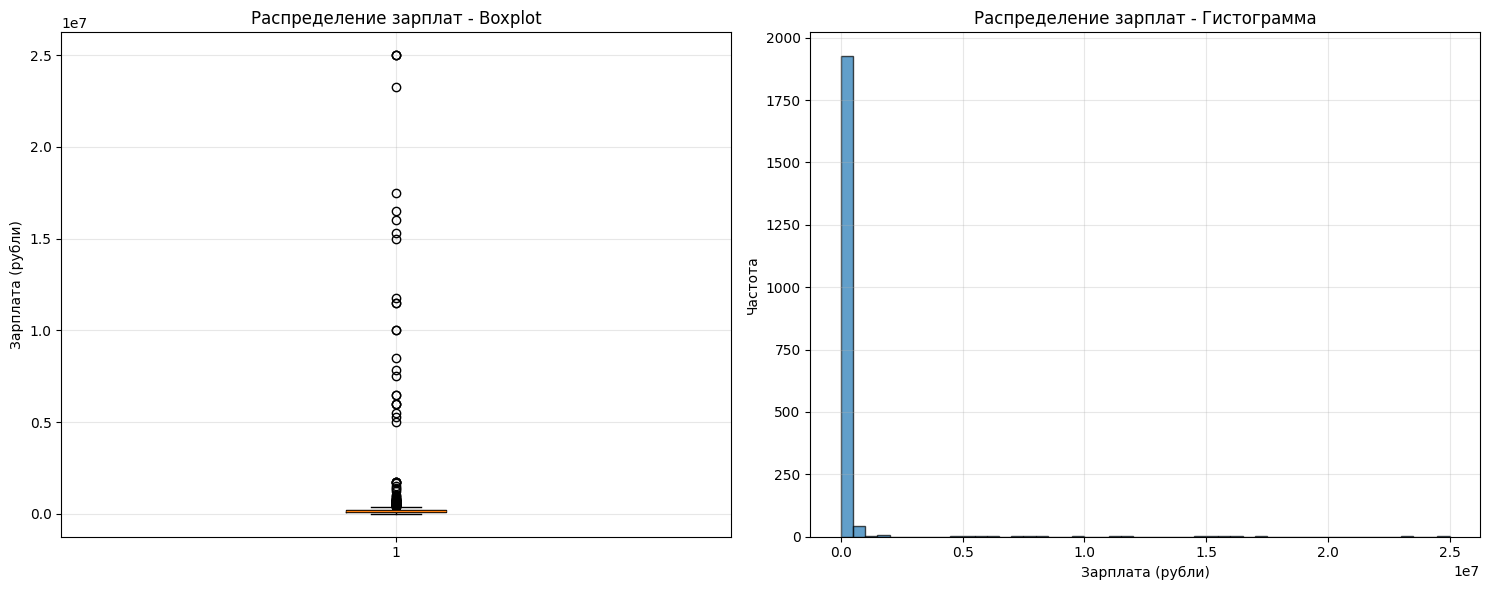

Результаты анализа Boxplot:
Всего записей о зарплатах: 2000
Q1 (25-й процентиль): 80,000
Q3 (75-й процентиль): 200,000
IQR: 120,000
Нижняя граница (Q1 - 1.5*IQR): -100,000
Верхняя граница (Q3 + 1.5*IQR): 380,000
Количество выбросов: 117
Процент выбросов: 5.85%

Диапазон зарплат выбросов: 390,000 - 25,000,000


In [23]:
salary_data = df_2['clean_sal'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].boxplot(salary_data, vert=True)
axes[0].set_title('Распределение зарплат - Boxplot')
axes[0].set_ylabel('Зарплата (рубли)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(salary_data, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title('Распределение зарплат - Гистограмма')
axes[1].set_xlabel('Зарплата (рубли)')
axes[1].set_ylabel('Частота')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Q1 = salary_data.quantile(0.25)
Q3 = salary_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = salary_data[(salary_data < lower_bound) | (salary_data > upper_bound)]

print("Результаты анализа Boxplot:")
print(f"Всего записей о зарплатах: {len(salary_data)}")
print(f"Q1 (25-й процентиль): {Q1:,.0f}")
print(f"Q3 (75-й процентиль): {Q3:,.0f}")
print(f"IQR: {IQR:,.0f}")
print(f"Нижняя граница (Q1 - 1.5*IQR): {lower_bound:,.0f}")
print(f"Верхняя граница (Q3 + 1.5*IQR): {upper_bound:,.0f}")
print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов: {len(outliers)/len(salary_data)*100:.2f}%")

if len(outliers) > 0:
    print(f"\nДиапазон зарплат выбросов: {outliers.min():,.0f} - {outliers.max():,.0f}")

lower_bound, upper_bound, outliers = lower_bound, upper_bound, outliers


## 6. Методы обнаружения аномалий без учителя
Реализация трех различных методов обнаружения аномалий без учителя с использованием библиотеки `pyod`.

**Три выбранных метода обнаружения аномалий и их реализация:**
1. **Isolation Forest (IForest)**: Древовидный метод, который изолирует аномалии путем случайного выбора признаков и значений разделения
2. **Local Outlier Factor (LOF)**: Метод на основе плотности, который сравнивает локальную плотность точки с ее соседями
3. **One-Class SVM (OCSVM)**: Подход на основе машин опорных векторов, который изучает границу решения вокруг нормальных данных


In [24]:
valid_data = df_2.dropna(subset=['clean_sal']).copy()

X = valid_data[['clean_sal']].values

print(f"Применяем обнаружение аномалий к {len(X)} записям с валидными данными о зарплате...")

print("\n1. Обучаем Isolation Forest...")
iforest = IForest(contamination=0.1, random_state=42)
iforest.fit(X)
anomaly1_scores = iforest.decision_function(X)
anomaly1_labels = iforest.predict(X)

print("2. Обучаем Local Outlier Factor...")
lof = LOF(contamination=0.1, n_neighbors=20)
lof.fit(X)
anomaly2_scores = lof.decision_function(X)
anomaly2_labels = lof.predict(X)

print("3. Обучаем One-Class SVM...")
ocsvm = OCSVM(contamination=0.1, kernel='rbf', gamma='scale')
ocsvm.fit(X)
anomaly3_scores = ocsvm.decision_function(X)
anomaly3_labels = ocsvm.predict(X)

valid_data['anomaly1'] = anomaly1_labels
valid_data['anomaly2'] = anomaly2_labels
valid_data['anomaly3'] = anomaly3_labels
valid_data['anomaly1_score'] = anomaly1_scores
valid_data['anomaly2_score'] = anomaly2_scores
valid_data['anomaly3_score'] = anomaly3_scores

df_3 = df_2.copy()
df_3 = df_3.merge(
    valid_data[['id', 'anomaly1', 'anomaly2', 'anomaly3', 'anomaly1_score', 'anomaly2_score', 'anomaly3_score']], 
    on='id', 
    how='left'
)

print("\nРезультаты обнаружения аномалий:")
print(f"Метод 1 (IForest) - Обнаружено аномалий: {valid_data['anomaly1'].sum()}")
print(f"Метод 2 (LOF) - Обнаружено аномалий: {valid_data['anomaly2'].sum()}")
print(f"Метод 3 (OCSVM) - Обнаружено аномалий: {valid_data['anomaly3'].sum()}")


Применяем обнаружение аномалий к 2000 записям с валидными данными о зарплате...

1. Обучаем Isolation Forest...
2. Обучаем Local Outlier Factor...
3. Обучаем One-Class SVM...

Результаты обнаружения аномалий:
Метод 1 (IForest) - Обнаружено аномалий: 198
Метод 2 (LOF) - Обнаружено аномалий: 195
Метод 3 (OCSVM) - Обнаружено аномалий: 200


## 7. Голосование большинством для финальной классификации аномалий
Реализация голосования большинством для создания финальной колонки `anomaly` на основе трех результатов обнаружения аномалий.

**Логика голосования большинством:**
- Для каждой записи подсчитывается, сколько методов классифицировали ее как аномалию (1) или нормальную (0)
- Если 2 или более методов согласны с классификацией аномалии, помечается как аномалия
- Этот подход обеспечивает более надежное обнаружение аномалий путем комбинирования нескольких методов


In [25]:
df_4 = df_3.copy()

anomaly_cols = ['anomaly1', 'anomaly2', 'anomaly3']
for col in anomaly_cols:
    df_4[col] = df_4[col].fillna(0)

df_4['anomaly_vote_sum'] = df_4[anomaly_cols].sum(axis=1)
df_4['anomaly'] = (df_4['anomaly_vote_sum'] >= 2).astype(int)

print("Результаты голосования большинством:")
print(f"Записей с 0 голосами (все методы говорят норма): {(df_4['anomaly_vote_sum'] == 0).sum()}")
print(f"Записей с 1 голосом (один метод говорит аномалия): {(df_4['anomaly_vote_sum'] == 1).sum()}")
print(f"Записей с 2 голосами (два метода говорят аномалия): {(df_4['anomaly_vote_sum'] == 2).sum()}")
print(f"Записей с 3 голосами (все методы говорят аномалия): {(df_4['anomaly_vote_sum'] == 3).sum()}")
print(f"\nФинальное количество аномалий: {df_4['anomaly'].sum()}")
print(f"Процент аномалий: {df_4['anomaly'].mean()*100:.2f}%")

print("\nАнализ согласованности методов:")
for i, col1 in enumerate(anomaly_cols):
    for j, col2 in enumerate(anomaly_cols):
        if i < j:
            agreement = (df_4[col1] == df_4[col2]).mean()
            print(f"{col1} vs {col2}: {agreement:.2%} согласованность")


Результаты голосования большинством:
Записей с 0 голосами (все методы говорят норма): 1578
Записей с 1 голосом (один метод говорит аномалия): 251
Записей с 2 голосами (два метода говорят аномалия): 171
Записей с 3 голосами (все методы говорят аномалия): 0

Финальное количество аномалий: 171
Процент аномалий: 8.55%

Анализ согласованности методов:
anomaly1 vs anomaly2: 81.55% согласованность
anomaly1 vs anomaly3: 96.00% согласованность
anomaly2 vs anomaly3: 80.25% согласованность


## 8. Анализ и категоризация аномалий
Для каждой обнаруженной аномалии проанализировать характеристики работы и создать объяснительные категории.

**Методология анализа аномалий и подход к категоризации:**
- Анализ названия работы, требуемого опыта, региона и требований к работе для каждой аномалии
- Создание объяснительных категорий на основе общих паттернов
- Добавление описательного текста, объясняющего суть каждого типа аномалии


In [26]:
df_5 = df_4.copy()

df_5['anomaly_category'] = ''
df_5['anomaly_explanation'] = ''

anomalies = df_5[df_5['anomaly'] == 1].copy()

print(f"Анализируем {len(anomalies)} обнаруженных аномалий...")

if len(anomalies) == 0:
    print("Аномалии не обнаружены для анализа.")
else:
    salary_stats = anomalies['clean_sal'].describe()
    print(f"\nСтатистика зарплат аномалий:")
    print(salary_stats)
    
    def categorize_anomaly(row):
        if pd.isna(row['clean_sal']):
            return 'Missing_Salary', 'Вакансия с отсутствующей информацией о зарплате'
        
        salary = row['clean_sal']
        all_salaries = df_5['clean_sal'].dropna()
        high_threshold = all_salaries.quantile(0.95)
        low_threshold = all_salaries.quantile(0.05)
        
        if salary >= high_threshold:
            experience = row.get('experience_name', 'Неизвестно')
            region = row.get('area_name', 'Неизвестно')
            return 'High_Salary', f'Исключительно высокая зарплата ({salary:,.0f} RUB) для {experience} в {region}'
        
        if salary <= low_threshold:
            experience = row.get('experience_name', 'Неизвестно')
            region = row.get('area_name', 'Неизвестно')
            return 'Low_Salary', f'Необычно низкая зарплата ({salary:,.0f} RUB) для {experience} в {region}'
        
        experience = row.get('experience_name', '')
        if 'Senior' in experience or 'Lead' in experience:
            if salary < all_salaries.quantile(0.3):
                return 'Experience_Mismatch', f'Низкая зарплата ({salary:,.0f} RUB) для старшей позиции'
        
        if 'Junior' in experience or 'Intern' in experience:
            if salary > all_salaries.quantile(0.8):
                return 'Experience_Mismatch', f'Высокая зарплата ({salary:,.0f} RUB) для младшей позиции'
        
        region = row.get('area_name', '')
        if 'Москва' in region or 'Санкт-Петербург' in region:
            if salary < all_salaries.quantile(0.2):
                return 'Regional_Mismatch', f'Низкая зарплата ({salary:,.0f} RUB) для позиции в крупном городе'
        
        return 'Other_Anomaly', f'Обнаружена аномалия зарплаты ({salary:,.0f} RUB) - требует дальнейшего расследования'
    
    for idx, row in anomalies.iterrows():
        category, explanation = categorize_anomaly(row)
        df_5.loc[idx, 'anomaly_category'] = category
        df_5.loc[idx, 'anomaly_explanation'] = explanation
    
    print("\nРезультаты категоризации аномалий:")
    category_counts = df_5[df_5['anomaly'] == 1]['anomaly_category'].value_counts()
    for category, count in category_counts.items():
        print(f"{category}: {count} аномалий")
    
    print("\nПримеры объяснений аномалий:")
    sample_anomalies = df_5[df_5['anomaly'] == 1][['name', 'clean_sal', 'anomaly_category', 'anomaly_explanation']].head(10)
    for idx, row in sample_anomalies.iterrows():
        print(f"\nРабота: {row['name']}")
        print(f"Зарплата: {row['clean_sal']:,.0f} RUB")
        print(f"Категория: {row['anomaly_category']}")
        print(f"Объяснение: {row['anomaly_explanation']}")


Анализируем 171 обнаруженных аномалий...

Статистика зарплат аномалий:
count    1.710000e+02
mean     2.192395e+06
std      4.856221e+06
min      3.000000e+02
25%      3.500000e+05
50%      4.750000e+05
75%      7.250000e+05
max      2.500000e+07
Name: clean_sal, dtype: float64

Результаты категоризации аномалий:
High_Salary: 100 аномалий
Other_Anomaly: 50 аномалий
Low_Salary: 13 аномалий
Regional_Mismatch: 8 аномалий

Примеры объяснений аномалий:

Работа: Менеджер по продажам B2B
Зарплата: 700,000 RUB
Категория: High_Salary
Объяснение: Исключительно высокая зарплата (700,000 RUB) для От 1 года до 3 лет в Шымкент

Работа: Менеджер по продажам B2B
Зарплата: 700,000 RUB
Категория: High_Salary
Объяснение: Исключительно высокая зарплата (700,000 RUB) для От 1 года до 3 лет в Актобе

Работа: Менеджер по продажам B2B
Зарплата: 700,000 RUB
Категория: High_Salary
Объяснение: Исключительно высокая зарплата (700,000 RUB) для От 1 года до 3 лет в Актау

Работа: Frontend Разработчик
Зарплата: 850 

## 9. Экспорт результатов
Экспорт финального DataFrame со всеми результатами анализа в файл Excel для дальнейшего анализа и отчетности.


In [27]:
export_columns = [
    'id', 'name', 'area_name', 'salary_from', 'salary_to', 'salary_gross', 
    'salary_currency', 'snippet_requirements', 'experience_name', 'clean_sal',
    'anomaly1', 'anomaly2', 'anomaly3', 'anomaly_vote_sum', 'anomaly',
    'anomaly_category', 'anomaly_explanation'
]

export_df = df_5[export_columns].copy()

output_path = f'/Users/23108022/Documents/repositories/mephi-data-analysis-part2-2025-fall/solutions/LR/lr1.xls'
export_df.to_excel(output_path, index=False, engine='openpyxl')

print(f"Результаты успешно экспортированы в: {output_path}")
print(f"Экспортировано {len(export_df)} записей с {len(export_columns)} колонками")

print("\nФинальное резюме анализа:")
print(f"Всего проанализировано вакансий: {len(df_5)}")
print(f"Вакансий с данными о зарплате: {df_5['clean_sal'].notna().sum()}")
print(f"Обнаружено аномалий: {df_5['anomaly'].sum()}")
print(f"Процент аномалий: {df_5['anomaly'].mean()*100:.2f}%")

if df_5['anomaly'].sum() > 0:
    print("\nКатегории аномалий:")
    category_summary = df_5[df_5['anomaly'] == 1]['anomaly_category'].value_counts()
    for category, count in category_summary.items():
        print(f"  {category}: {count}")


Результаты успешно экспортированы в: /Users/23108022/Documents/repositories/mephi-data-analysis-part2-2025-fall/solutions/LR/lr1.xls
Экспортировано 2000 записей с 17 колонками

Финальное резюме анализа:
Всего проанализировано вакансий: 2000
Вакансий с данными о зарплате: 2000
Обнаружено аномалий: 171
Процент аномалий: 8.55%

Категории аномалий:
  High_Salary: 100
  Other_Anomaly: 50
  Low_Salary: 13
  Regional_Mismatch: 8
